# IEEE-CIS Fraud Detection 
## Can You Detect Frauduelent Transactions 
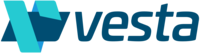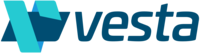

Imagine standing at the check-out counter at the grocery store with a long line behind you and the cashier not-so-quietly announces that your card has been declined. In this moment, you probably aren’t thinking about the data science that determined your fate.

Embarrassed, and certain you have the funds to cover everything needed for an epic nacho party for 50 of your closest friends, you try your card again. Same result. As you step aside and allow the cashier to tend to the next customer, you receive a text message from your bank. “Press 1 if you really tried to spend $500 on cheddar cheese.”

While perhaps cumbersome (and often embarrassing) in the moment, this fraud prevention system is actually saving consumers millions of dollars per year. Researchers from the IEEE Computational Intelligence Society (IEEE-CIS) want to improve this figure, while also improving the customer experience. With higher accuracy fraud detection, you can get on with your chips without the hassle.

====================================================================================

**Disclaimer:** *The following notebooks are used for analysis purposes.*

We will use the IEEE-Fraud Detection dataset available on [kaggle.com](https://www.kaggle.com/c/ieee-fraud-detection/data). See below for more details.

====================================================================================

**What is the objective of the machine learning model?**

We aim find a model that has a good measure of seperability. We will evaluate the model perfromance with the: 
- [ROC-AUC](https://towardsdatascience.com/comprehension-of-the-auc-roc-curve-e876191280f9)


**Disclaimer:** *The structure used in this notebook was taken from the Deployment of Machine Learning Models course on Udemy*

In [70]:
# to handle datasets
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# load data
train_transaction = pd.read_csv("../data/train_transaction.csv")
train_identity = pd.read_csv("../data/train_identity.csv")

# number of rows and columns in the datasets
print(f"train transaction: {train_transaction.shape}\n\
train identity: {train_identity.shape}")

train transaction: (590540, 394)
train identity: (144233, 41)


The train transaction dataset contains 590540 rows, that is the number of customers, and 394 columns, i.e., features. On the other hand, The train identity dataset contains 144233 rows, and 41 columns. 

Altogether, there are 433 predictive features and 1 is the target variable: isFraud

In [72]:
# preview transaction dataset
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# preview identity dataset
train_identity.head() 

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [74]:
# combine the datasets, which are joined by TransactionID.
# Not all transactions have corresponding identity information.
dataset = pd.merge(
    train_transaction,
    train_identity,
    how="left", 
    on="TransactionID"
)

# check merged correctly
print(f"merged dataset rows and cols: {dataset.shape}")

merged dataset rows and cols: (590540, 434)


## Analysis
**We will analyse the following:**
1. The target feature
2. Feature types (categorical and numerical)
3. Missing data
    - Numerical variables
    - Categorical variables

### 1. The target feature

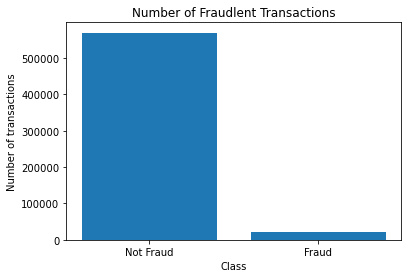

In [75]:
# bar chart to evaluate target distribution
x = ["Not Fraud", "Fraud"]
height = list(dataset["isFraud"].value_counts())

plt.bar(
    x= x,
    height= dataset["isFraud"].value_counts()
)

plt.title("Number of Fraudlent Transactions")
plt.xlabel("Class")
plt.ylabel("Number of transactions") 
plt.show()

We can see that the target label is discrete, and there is a severe imbalance of the classes. We could potentially apply some sampling techniques to balance the classes - see [Oversampling and Undersampling](https://towardsdatascience.com/oversampling-and-undersampling-5e2bbaf56dcf).

For now, I'm going to leave it as it is. 

### 2. Feature Types (Categorical and Numerical)
The documentation tells us the following: 

1. Categorical Features - Transaction
    - `ProductCD`
    - `card1 - card6`
    - `addr1, addr2`
    - `P_emaildomain`
    - `R_emaildomain`
    - `M1 - M9`
2. Categorical Features - Identity
    - `DeviceType`
    - `DeviceInfo`
    - `id_12 - id_38`

We are first going to confirm that the actual data aligns with what the documentation states. 

In [76]:
# identifying the categorical features by 
# capturing those of type *object*
cat_cols = list(dataset.select_dtypes(include=['object']).columns)
print(f"length: {len(cat_cols)}\n\n\
columns:\n{cat_cols}")

length: 31

columns:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


The object list does not include the following features:
`card1`, `card2`, `card3`, `card5`, `addr1`, `addr2`, `id_13`, `id_14`, `id_17`, `id_18`, `id_19`, `id_20`, `id_21`, `id_22`, `id_24`, `id_25`, `id_26`, `id_32`.

This means that these features must be of some other type, even though they are regarded as categorical features. Let's check what type they are of...

In [77]:
# checking the datatype of features that
# are documented as categorical
dataset[["card1", "card2", "card3", "card5", 
         "addr1", "addr2", "id_13", "id_14", 
         "id_17", "id_18", "id_19", "id_20", 
         "id_21", "id_22", "id_24", "id_25",
         "id_26", "id_32"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   card1   590540 non-null  int64  
 1   card2   581607 non-null  float64
 2   card3   588975 non-null  float64
 3   card5   586281 non-null  float64
 4   addr1   524834 non-null  float64
 5   addr2   524834 non-null  float64
 6   id_13   127320 non-null  float64
 7   id_14   80044 non-null   float64
 8   id_17   139369 non-null  float64
 9   id_18   45113 non-null   float64
 10  id_19   139318 non-null  float64
 11  id_20   139261 non-null  float64
 12  id_21   5159 non-null    float64
 13  id_22   5169 non-null    float64
 14  id_24   4747 non-null    float64
 15  id_25   5132 non-null    float64
 16  id_26   5163 non-null    float64
 17  id_32   77586 non-null   float64
dtypes: float64(17), int64(1)
memory usage: 85.6 MB


All are `float64` apart from `card1` which is `int64`. Let's convert them all so that they are of type `object`. 

In [78]:
# adding these features to the catergorical columns
cat_cols += ["card1", "card2", "card3", "card5", 
             "addr1", "addr2", "id_13", "id_14", 
             "id_17", "id_18", "id_19", "id_20", 
             "id_21", "id_22", "id_24", "id_25",
             "id_26", "id_32"]

# be careful, multiple runs will corrupt the list
print(len(cat_cols))

# casting all of these features to categorical
dataset[cat_cols] = dataset[cat_cols].astype("O")

49


There are 434 columns and we know that 49 of them are categorical and 1 is our target variable which means there are 384 features left that we don't know the datatype for...
$$434 - 50 = 384$$

The documentation states that the `TransactionDT` feature is a timedelta from a given reference datetime (not an actual timestamp). First, we will check it's current datatype...

In [79]:
# checking datatype
dataset[["TransactionDT"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   TransactionDT  590540 non-null  int64
dtypes: int64(1)
memory usage: 9.0 MB


It's currently of `int64` datatype so we will leave it for now.


Next, we will gather all the numeric features that arent in the categorical variables or is not the target variable to see how many of the 384 features left are numeric.

In [80]:
# colelcting all numerical features
# that aren't the target label or in the cat_cols
num_cols = [x for x in dataset.select_dtypes(include=['number']).columns
            if x not in cat_cols
            if x not in "isFraud"]
print(len(num_cols))

384


We can confirm that the remaining 384 features are numerical. 

### 3. Missing Values
Many machine learning models require us to deal with missing values before passing the
training data to it. Understanding the features with missing values could provide us some
insight into how to deal with that particular feature (i.e. imputation or deletion). 

In [81]:
#  a list of the variables that contain missing values
features_with_na = [var for var in dataset.columns if dataset[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data
missing_values_df = pd.DataFrame(dataset[features_with_na].isnull().mean().sort_values(ascending=False), columns=["percentage"])
missing_values_df.head(10)

,percentage
id_24,0.991962
id_25,0.991310
id_07,0.991271
id_08,0.991271
id_21,0.991264
id_26,0.991257
id_27,0.991247
id_23,0.991247
id_22,0.991247
dist2,0.936284


Our dataset contains many features with large portion of missing values. For example, the first 10 features in our list are missing 93%+ of values.

To train a Machine Learning model on this dataset, we would have to impute those missing values. The ones with a large portion of values may not be worth dealing with, since they've lost so much information, so we can consider removing them from the model. 

Let's see how many of missing features are above some random thresholds. 

In [82]:
# how many features are missing more than some random threshold? 
print(
    f"25%: {len(missing_values_df[missing_values_df['percentage'] > 0.25])}\n\
50%: {len(missing_values_df[missing_values_df['percentage'] > 0.5])}\n\
75%: {len(missing_values_df[missing_values_df['percentage'] > 0.75])}\n\
80%: {len(missing_values_df[missing_values_df['percentage'] > 0.80])}\n\
90%: {len(missing_values_df[missing_values_df['percentage'] > 0.90])}"
)   

25%: 252
50%: 214
75%: 208
80%: 74
90%: 12


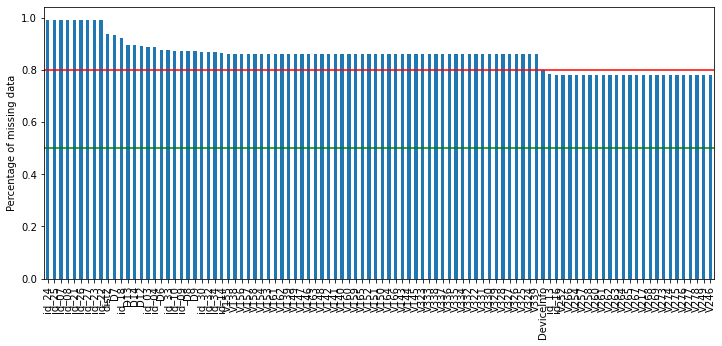

In [83]:
# plot
missing_values_df[:100].plot.bar(figsize=(12, 5), legend=None)
plt.ylabel('Percentage of missing data')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.axhline(y=0.50, color='g', linestyle='-')
plt.xticks(rotation=90)
plt.show()

A large portion of features (74) are missing more than 80% of values. Since the instances are annonymized for the protection of the customers, we can **consider** dropping features with high number of missing values as **there may be no clear way to identify how to engineer these features.** To begin with, I will start by separating the features into categorical and numerical. 

In [84]:
# determine which features, from those with missing data,
# are numerical and which are categorical

cat_na = [feat for feat in cat_cols if feat in features_with_na]
num_na = [feat for feat in num_cols if feat in features_with_na]

print('Number of categorical variables with na: ', len(cat_na))
print('Number of numerical variables with na: ', len(num_na))

Number of categorical variables with na:  47
Number of numerical variables with na:  367


The categorical features have 47/49 of missing values, and the numerical features have 367 of 384.  

It would be good to know what percentage of missing values each one contains. 

In [85]:
# missing value percentages of categorical features at random thresholds
print(
    f"25%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.25)}\n\
50%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.5)}\n\
75%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.75)}\n\
80%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.8)}\n\
90%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.9)}"
)  

25%: 39
50%: 34
75%: 30
80%: 13
90%: 8


In [86]:
# missing value percentages of categorical features at random thresholds
print(
    f"25%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.25)}\n\
50%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.5)}\n\
75%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.75)}\n\
80%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.8)}\n\
90%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.9)}"
)

25%: 213
50%: 180
75%: 178
80%: 61
90%: 4


There is definitely more analysis that can be performed to better grasp the nature of this data. For instance, we could perform more anaysis to understand the relationship of the features with the target, and we can look at the distributions of the features itself. 

However, I personally prefer to carry out that step after fitting some models to the data and understanding why certain features are more important than others. 